In [3]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.transform import resize 
from skimage import data 
from scipy.misc import imresize 

In [4]:
import tensorflow as tf

from libs import gif, utils

In [5]:
x = tf.placeholder(tf.float32, shape = (None, 2), name = "x")

In [6]:
w = tf.get_variable(name = "w", shape = [2, 20], initializer = tf.random_normal_initializer)

In [7]:
b = tf.get_variable(name="b", shape=[20], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, w),
            bias=b)

In [8]:
activation = tf.nn.relu
if activation:
    h = activation(h)

In [9]:
h, W = utils.linear(
    x=x, n_output=20, name='linear', activation=tf.nn.relu)

Instructions for updating:
Use the retry module or similar alternatives.


In [10]:
#loading an image in python using PIL
from PIL import Image as pim

In [11]:
img = pim.open("profile.jpg")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


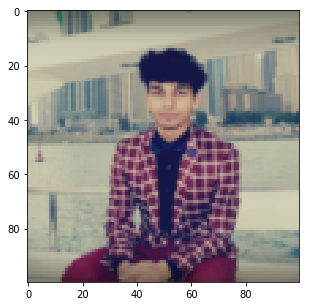

In [12]:
img = imresize(img, (100, 100))
plt.figure(figsize=(5, 5))
plt.imshow(img)

In [13]:
plt.imsave(fname='reference.png', arr=img)

In [14]:
def split_image(img):
    
    #image poisition inputs (row, column)
    xs = []
    #the RGB colors at (row, column)
    ys = []
    
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            xs.append([row, col])
            ys.append(img[row, col])
            
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

In [15]:
xs, ys = split_image(img)

# and print the shapes
xs.shape, ys.shape

((10000, 2), (10000, 3))

In [16]:
xs = (xs - np.mean(xs)) / np.std(xs)

print(np.min(xs), np.max(xs))
assert(np.min(xs) > -3.0 and np.max(xs) < 3.0)

-1.7148160424389376 1.7148160424389376


In [17]:
ys = ys / 255.0
print(np.min(ys), np.max(ys))

0.047058823529411764 0.8274509803921568


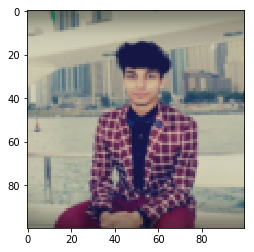

In [18]:
plt.imshow(ys.reshape(img.shape))

In [19]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, 2), name="X")
Y = tf.placeholder(dtype=tf.float32, shape=(None, 3), name="Y")


In [20]:
# number of neurons per layer (there will be 6 hidden layers 
# in this network)
n_neurons = 20

h1, W = utils.linear(
    x=X, n_output=n_neurons, name='l1', activation=tf.nn.relu)

h2, W2 = utils.linear(
    x=h1, n_output=n_neurons, name='l2', activation=tf.nn.relu)

h3, W3 = utils.linear(
    x=h2, n_output=n_neurons, name='l3', activation=tf.nn.relu)

h4, W4 = utils.linear(
    x=h3, n_output=n_neurons, name='l4', activation=tf.nn.relu)

h5, W5 = utils.linear(
    x=h4, n_output=n_neurons, name='l5', activation=tf.nn.relu)

h6, W6 = utils.linear(
    x=h5, n_output=n_neurons, name='l6', activation=tf.nn.relu)

Y_pred, W7 = utils.linear(h6, 3, activation=None, name='pred')

In [21]:
assert(X.get_shape().as_list() == [None, 2])
assert(Y_pred.get_shape().as_list() == [None, 3])
assert(Y.get_shape().as_list() == [None, 3])

In [22]:
error = tf.squared_difference(Y, Y_pred)
assert(error.get_shape().as_list() == [None, 3])

In [23]:
sum_error = tf.reduce_sum(error, reduction_indices=1)
assert(sum_error.get_shape().as_list() == [None])

In [26]:
cost = tf.reduce_mean(sum_error, reduction_indices=0)
assert(cost.get_shape().as_list() == [])

In [29]:
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

n_iterations = 99

batch_size = 200

#creating a session
sess = tf.Session()

In [ ]:
# Initialize all your variables and run the operation with your session
sess.run(tf.global_variables_initializer())

# Optimize over a few iterations, each time following the gradient
# a little at a time
imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0



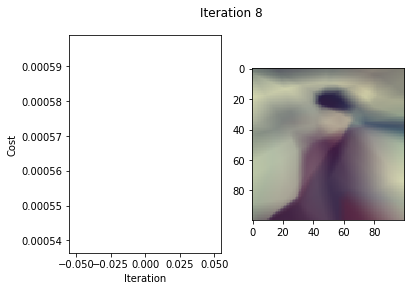

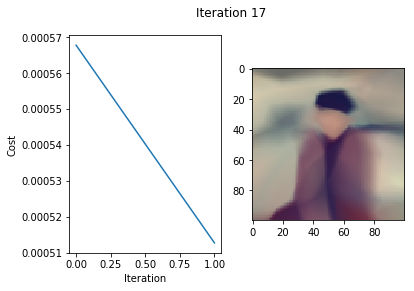

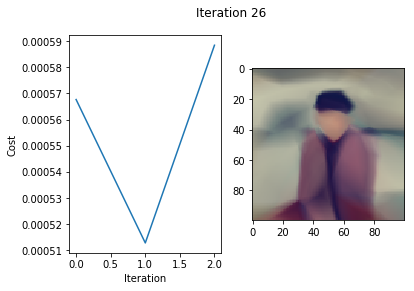

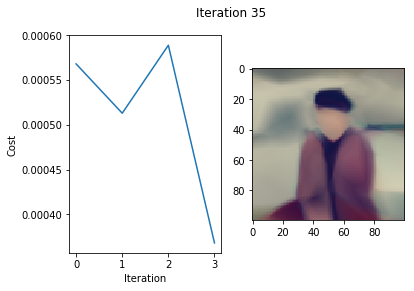

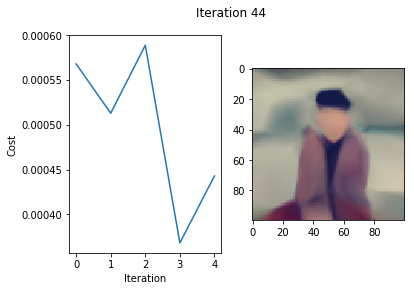

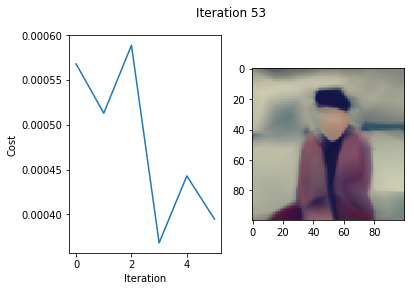

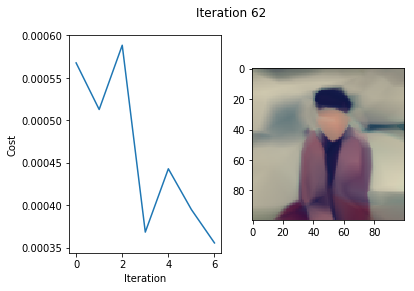

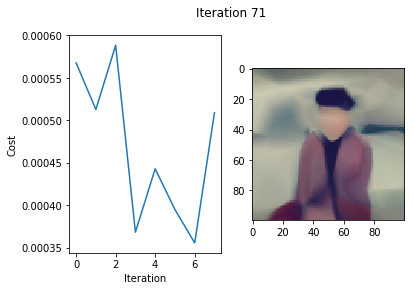

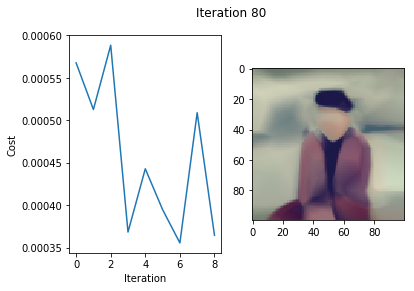

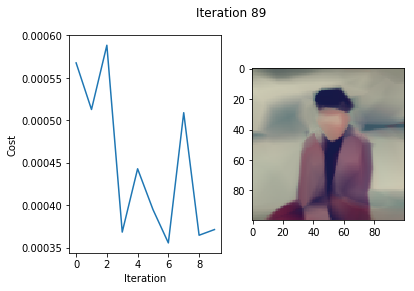

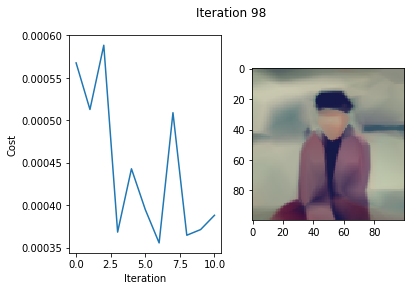

In [49]:
# Initialize all your variables and run the operation with your session
sess.run(tf.global_variables_initializer())

# Optimize over a few iterations, each time following the gradient
# a little at a time
imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0

for it_i in range(n_iterations):
    
    # Get a random sampling of the dataset
    idxs = np.random.permutation(range(len(xs)))
    
    # The number of batches we have to iterate over
    n_batches = len(idxs) // batch_size
    
    # Now iterate over our stochastic minibatches:
    for batch_i in range(n_batches):
         
        # Get just minibatch amount of data
        idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]

        # And optimize, also returning the cost so we can monitor
        # how our optimization is doing.
        training_cost = sess.run(
            [cost, optimizer],
            feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})[0]

    # Also, every 20 iterations, we'll draw the prediction of our
    # input xs, which should try to recreate our image!
    if (it_i + 1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
        img = np.clip(ys_pred.reshape(img.shape), 0, 1)
        imgs.append(img)
        # Plot the cost over time
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Cost')
        ax[1].imshow(img)
        fig.suptitle('Iteration {}'.format(it_i))
        plt.show()

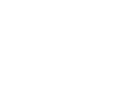

In [53]:
# Save the images as a GIF
_ = gif.build_gif(imgs, saveto='single.gif', show_gif=False)

Multiple Images

In [54]:
def build_model(xs, ys, n_neurons, n_layers, activation_fn,
                final_activation_fn, cost_type):
    
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if xs.ndim != 2:
        raise ValueError(
            'xs should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
    if ys.ndim != 2:
        raise ValueError(
            'ys should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
        
    n_xs = xs.shape[1]
    n_ys = ys.shape[1]
    
    X = tf.placeholder(name='X', shape=[None, n_xs],
                       dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=[None, n_ys],
                       dtype=tf.float32)

    current_input = X
    for layer_i in range(n_layers):
        current_input = utils.linear(
            current_input, n_neurons,
            activation=activation_fn,
            name='layer{}'.format(layer_i))[0]

    Y_pred = utils.linear(
        current_input, n_ys,
        activation=final_activation_fn,
        name='pred')[0]
    
    if cost_type == 'l1_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.abs(Y - Y_pred), 1))
    elif cost_type == 'l2_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.squared_difference(Y, Y_pred), 1))
    else:
        raise ValueError(
            'Unknown cost_type: {}.  '.format(
            cost_type) + 'Use only "l1_norm" or "l2_norm"')
    
    return {'X': X, 'Y': Y, 'Y_pred': Y_pred, 'cost': cost}

In [55]:
def train(imgs,
          learning_rate=0.0001,
          batch_size=200,
          n_iterations=10,
          gif_step=2,
          n_neurons=30,
          n_layers=10,
          activation_fn=tf.nn.relu,
          final_activation_fn=tf.nn.tanh,
          cost_type='l2_norm'):

    N, H, W, C = imgs.shape
    all_xs, all_ys = [], []
    for img_i, img in enumerate(imgs):
        xs, ys = split_image(img)
        all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
        all_ys.append(ys)
    xs = np.array(all_xs).reshape(-1, 3)
    xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
    ys = np.array(all_ys).reshape(-1, 3)
    ys = ys / 127.5 - 1

    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        model = build_model(xs, ys, n_neurons, n_layers,
                            activation_fn, final_activation_fn,
                            cost_type)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(model['cost'])
        sess.run(tf.global_variables_initializer())
        gifs = []
        costs = []
        step_i = 0
        for it_i in range(n_iterations):
            # Get a random sampling of the dataset
            idxs = np.random.permutation(range(len(xs)))

            # The number of batches we have to iterate over
            n_batches = len(idxs) // batch_size
            training_cost = 0

            # Now iterate over our stochastic minibatches:
            for batch_i in range(n_batches):

                # Get just minibatch amount of data
                idxs_i = idxs[batch_i * batch_size:
                              (batch_i + 1) * batch_size]

                # And optimize, also returning the cost so we can monitor
                # how our optimization is doing.
                cost = sess.run(
                    [model['cost'], optimizer],
                    feed_dict={model['X']: xs[idxs_i],
                               model['Y']: ys[idxs_i]})[0]
                training_cost += cost

            print('iteration {}/{}: cost {}'.format(
                    it_i + 1, n_iterations, training_cost / n_batches))

            # Also, every 20 iterations, we'll draw the prediction of our
            # input xs, which should try to recreate our image!
            if (it_i + 1) % gif_step == 0:
                costs.append(training_cost / n_batches)
                ys_pred = model['Y_pred'].eval(
                    feed_dict={model['X']: xs}, session=sess)
                img = ys_pred.reshape(imgs.shape)
                gifs.append(img)
        return gifs

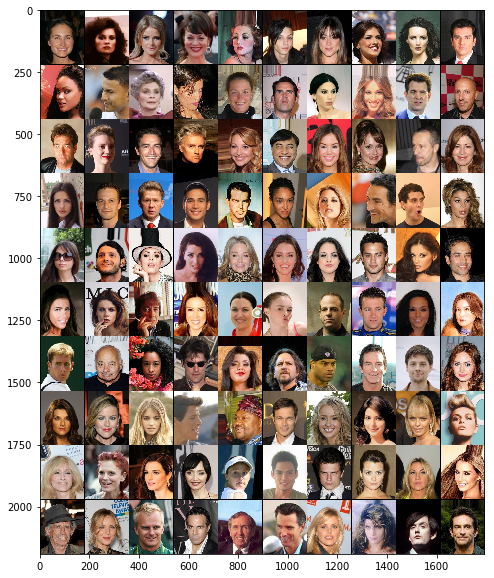

In [56]:
celeb_imgs = utils.get_celeb_imgs()
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(celeb_imgs).astype(np.uint8))
# It doesn't have to be 100 images, explore!
imgs = np.array(celeb_imgs).copy()

In [57]:
gifs = train(imgs=imgs)


iteration 1/10: cost 0.8933095226778393
iteration 2/10: cost 0.8424559570123161
iteration 3/10: cost 0.817282878198079
iteration 4/10: cost 0.7985567778222967
iteration 5/10: cost 0.7818866391155403
iteration 6/10: cost 0.7658174890898488
iteration 7/10: cost 0.7506536244608768
iteration 8/10: cost 0.7388313705943169
iteration 9/10: cost 0.7290031249689547
iteration 10/10: cost 0.7201948509967373


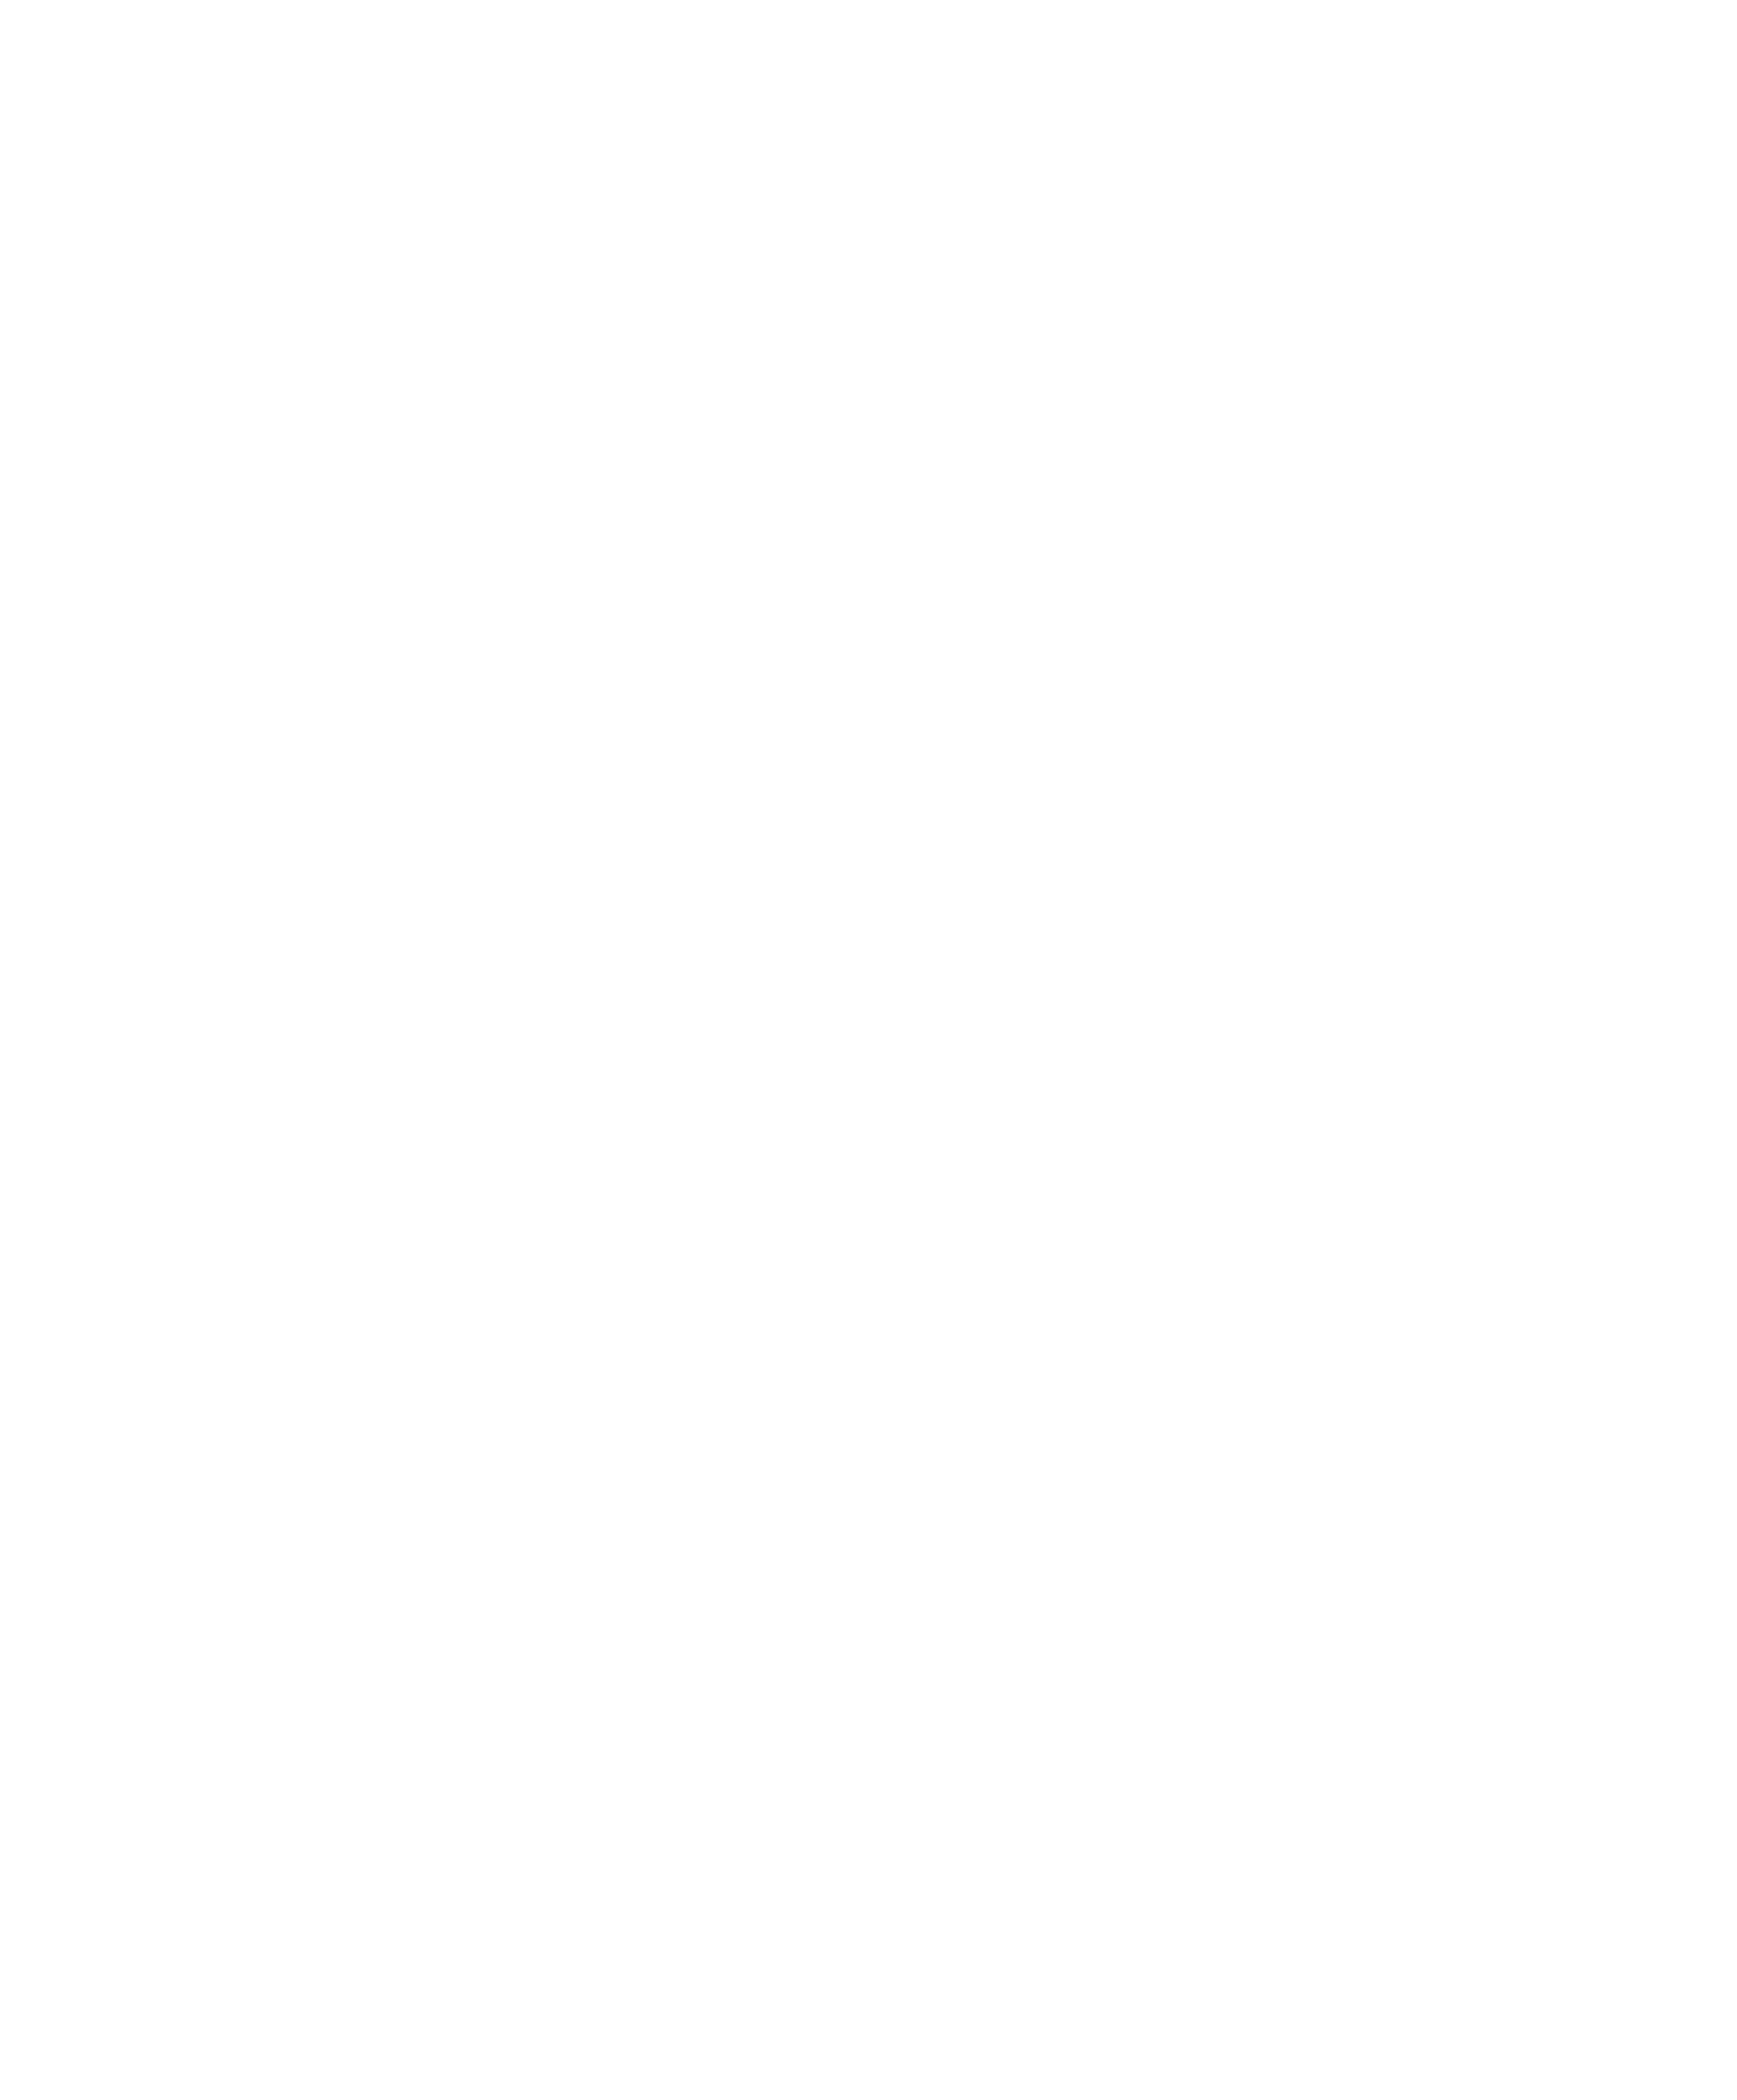

In [58]:
montage_gifs = [np.clip(utils.montage(
            (m * 127.5) + 127.5), 0, 255).astype(np.uint8)
                for m in gifs]
_ = gif.build_gif(montage_gifs, saveto='multiple.gif')